# Tikhonov regularization, the conjugate gradient method and the L-curve
Consider the problem from lab 3. Another approach that can avoid the effects of semi-convergence is to solve instead of the least-squares problem
$$ \min_{\alpha} \frac{1}{2} \| A \alpha - g \|^2 $$
the regularized problem
$$ \min_{\alpha} \frac{1}{2} \| A \alpha - g \|^2 + \frac{\lambda}{2} \| \alpha \|^2 $$
with a regularization parameter $\lambda > 0$. It turns out that for a suitably chosen parameter $\lambda$ (depending on the noise level and the problem) the exact solution of the regularized problem (here with [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization)) is often a more accurate reconstruction than a solution of the unregularized problem (though there are typically better regularization alternatives). The optimality condition now reads $0 = A^* (A \alpha - g) + \lambda \alpha$. For the reconstruction problem described in lab 3, find a regularized solution for some choice of $\lambda$ using the conjugate gradient method and plot the relative error. Then, try to find a good choice of the parameter $\lambda$ with the L-curve method - can be found in Müller&Siltanen. For the L-curve you should not do a full reconstruction for each $\lambda$, but only a few iterations to save time. Compare with the Landweber solution.

Some hints:

* As in lab 3, if you do not have a GPU, or if you have not installed astra-toolbox, then this lab must be done in two dimensions.

* You can form the [identity operator](https://odlgroup.github.io/odl/generated/odl.operator.default_ops.IdentityOperator.html) of a space and add a scaled version of it to another operator, in order to implement Tikhonov regularization.

* There are many [algorithmic solvers](https://odlgroup.github.io/odl/odl.solvers.html) available in ODL, including the [conjugate gradient](https://odlgroup.github.io/odl/generated/odl.solvers.iterative.iterative.conjugate_gradient.html) method, for which you need to make your operator self-adjoint.

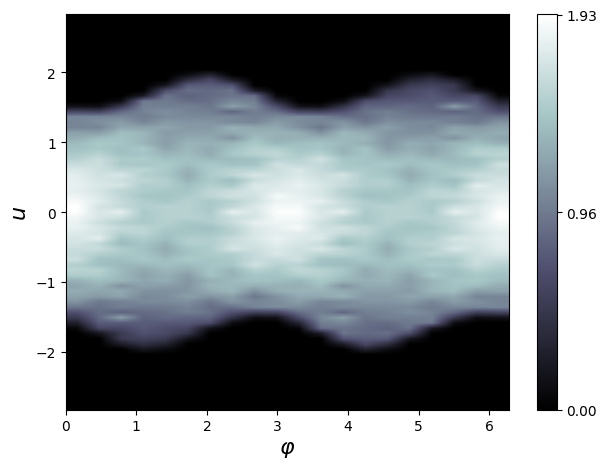

<Figure size 640x480 with 0 Axes>

0.6121936946120274
0.7393002758800337
0.336309718018344
-0.11990161800455287
0.5945392844529562


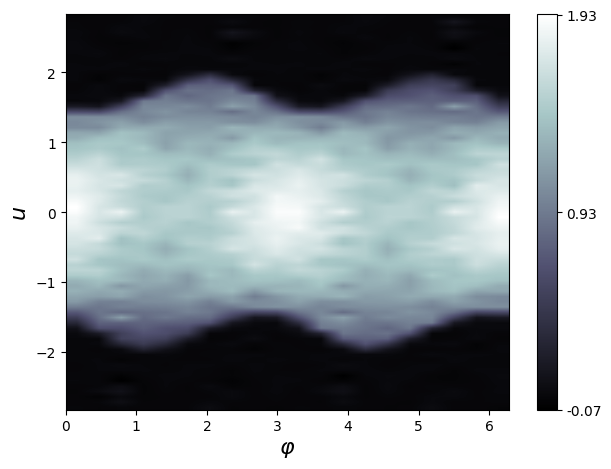

<Figure size 640x480 with 0 Axes>

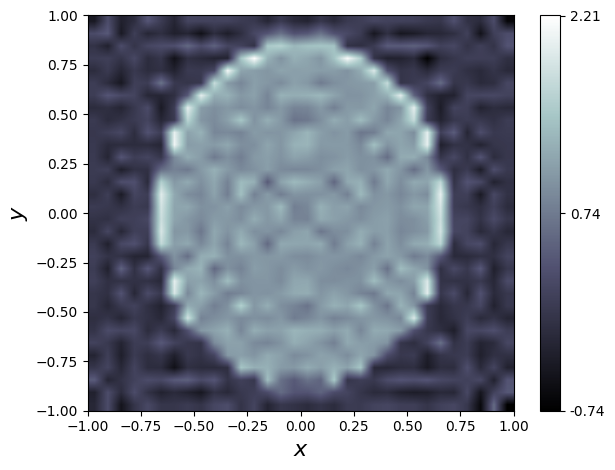

<Figure size 640x480 with 0 Axes>

Supress extra img


In [8]:
import odl
import numpy as np
import matplotlib.pyplot as plt


space = odl.uniform_discr([-1,-1,-1],[1,1,1], 32)

phant = odl.phantom.transmission.shepp_logan(space)

geo = odl.tomo.geometry.conebeam.cone_beam_geometry(space,2, 2, num_angles=20)

A = odl.tomo.operators.ray_trafo.RayTransform(space, geo, impl='astra_cuda')

Q = A(phant)
Q.show()

q = Q + odl.phantom.noise.white_noise(A.range, stddev=0.005)

g = A.adjoint(q)

alpha = 0.1 

x_axis = []
y_axis = []

n=40
alp_range = 2**np.linspace(-4, 5, n)
I = odl.operator.default_ops.IdentityOperator(space)
alpha = 0.05
A_reg = A.adjoint*A + alpha*I

ran = A.range

# For some reason A.adjoint doesn't seem to actually be the true adjoint of A?
for k in range(5):
    x = odl.phantom.noise.white_noise(space, stddev=1)
    y = odl.phantom.noise.white_noise(ran, stddev=1)    

    i1 = ran.inner(A(x),y)
    i2 = space.inner(x,A.adjoint(y))
    # print(i1)
    # print(i2)

    print(i1/i2)


old = 100.0
count = 0
for nin in range(1,40):
    u = space.zero()
    odl.solvers.iterative.iterative.conjugate_gradient(A_reg, u, A.adjoint(q), niter = nin)
    new = (A(u)-Q).norm()**2 + alpha * u.norm()**2
    if new > old:
        print("energy growing")
        print("iterations: ", nin-1)
        count +=1
        if count == 3:
            break
    old = new


A(u).show()
u.show()

print("Supress extra img")



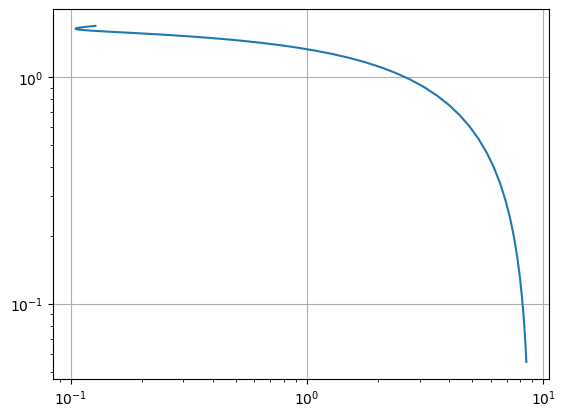

In [33]:
# L curve shit

alp_range = 2**np.linspace(-10,10,60)
x_axis = []
y_axis = []
nin = 40
for alpha in alp_range:
    A_reg = A.adjoint*A + alpha*I
    u = space.zero()
    odl.solvers.iterative.iterative.conjugate_gradient(A_reg, u, A.adjoint(q), niter = nin)
    x_axis.append((A(u)-q).norm())
    y_axis.append(u.norm())

plt.figure()
plt.loglog(x_axis,y_axis)
plt.grid()
plt.show()

[ 0.12746936  0.12721247  0.12689033  0.12648675  0.12598347
  0.12535757  0.12458296  0.1236304   0.12246803  0.12106473
  0.11939355  0.11744031  0.11521568  0.1127731   0.1102352
  0.10782359  0.10589175  0.10494031  0.10559705  0.10854204
  0.11439498  0.12363407  0.13661367  0.15367896  0.17530193
  0.20217032  0.23521615  0.27561272  0.32476819  0.38432985
  0.45619919  0.54254392  0.64579197  0.7685963   0.91376119
  1.08412161  1.28237314  1.5108583   1.77132679  2.06469963
  2.39087212  2.74857949  3.13532257  3.54732465  3.97949016
  4.42537869  4.87727291  5.32645342  5.76374961  6.1803207
  6.56850107  6.92249612  7.23876515  7.51604029  7.75504114
  7.95800729  8.12817698  8.26930894  8.38530046  8.47991697]
[  9.76562500e-04   1.23521942e-03   1.56238541e-03   1.97620613e-03
   2.49963334e-03   3.16169793e-03   3.99912005e-03   5.05834571e-03
   6.39812284e-03   8.09275961e-03   1.02362458e-02   1.29474658e-02
   1.63767922e-02   2.07144261e-02   2.62009460e-02   3.314065

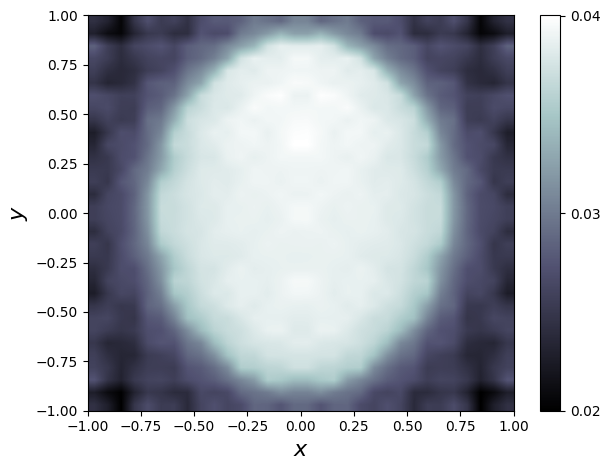

<Figure size 640x480 with 0 Axes>

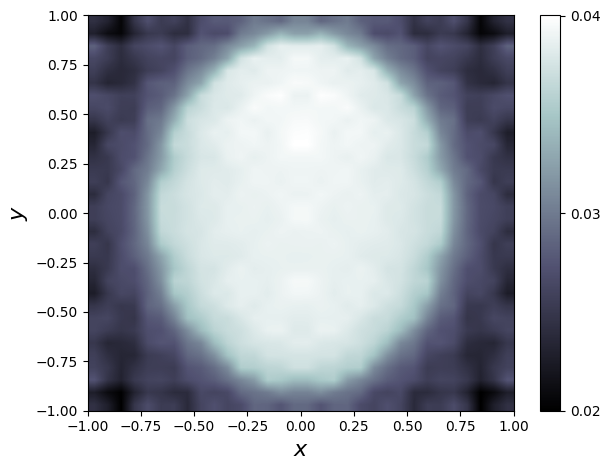

In [36]:
# Just choose the one giving minimum x-value? xd

print(np.array(x_axis))


print(alp_range)

a = np.argmin(np.array(x_axis))

# alpha = 2.62009460e-02
alpha = alp_range[a]

u = space.zero()
odl.solvers.iterative.iterative.conjugate_gradient(A_reg, u, A.adjoint(q), niter = 87)

u.show()